In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pca import pca

from   sklearn.pipeline           import Pipeline, FeatureUnion
from sklearn.preprocessing   import OneHotEncoder, QuantileTransformer, StandardScaler
from sklearn.impute          import SimpleImputer
from sklearn.compose         import ColumnTransformer
from sklearn.inspection import permutation_importance
from   sklearn.experimental    import enable_iterative_imputer
from   sklearn.impute          import *
from sklearn.base import clone 
from   sklearn.metrics            import accuracy_score 
# Models
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.ensemble        import RandomForestRegressor, StackingRegressor, BaggingRegressor
from sklearn.linear_model    import LogisticRegression, RidgeClassifier
import seaborn as sns
from scipy import stats
from xgboost import XGBClassifier
from collections import Counter
import warnings

warnings.filterwarnings('ignore')

In [249]:
df = pd.read_csv('train.csv')
df.columns
print(df.Survived.value_counts())
df.info()

# Relatively balanced class
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


0    549
1    342
Name: Survived, dtype: int64

In [250]:
# Drop PassengerId and Name because they are all unique
unique = ['PassengerId', 'Name']

y = df.Survived.values
X = df.copy()
X = df.drop(columns=unique)
X = X.drop(columns = ['Survived']) 


# The SibSp and Parch seem to have very similar distributions, lets check if they are multi-collinear
- We can attempt drop-column importance after fitting the initial model with just one of the columns

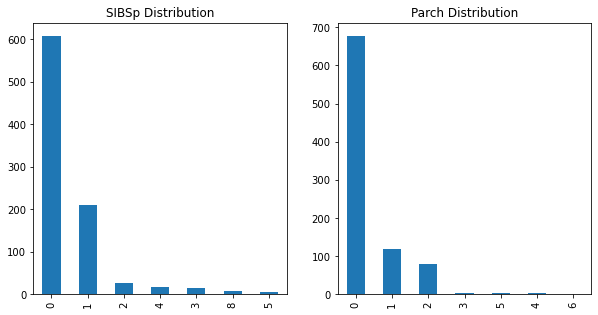

In [251]:
plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.title("SIBSp Distribution")
df.SibSp.value_counts().plot(kind='bar')
plt.subplot(1,2,2)
plt.title("Parch Distribution")
df.Parch.value_counts().plot(kind='bar')
plt.show()

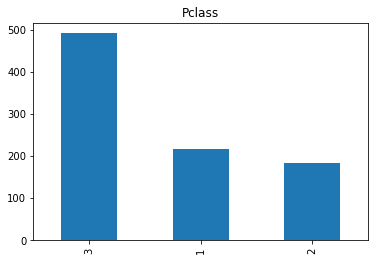

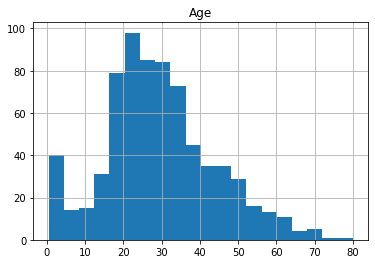

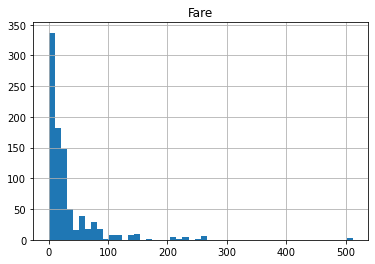

In [252]:
plt.title("Pclass")
df['Pclass'].value_counts().plot(kind='bar')
df.hist(column='Age', bins=20)
df.hist(column='Fare', bins=50)
plt.show()

# Mean Encoding (might be doing it wrong as it is encoding the entire set rather than basing on training set only)
Looks like being female and 1st or 2nd class means high probability of survival. <br>


In [254]:
sex_mean_encoded = df.groupby(['Sex'])['Survived'].mean()
class_mean_encoded = df.groupby(['Pclass'])['Survived'].mean()
embark_mean_encoded = df.groupby(['Embarked'])['Survived'].mean()
sex_class_mean_encoded = df.groupby(['Sex', 'Pclass'])['Survived'].mean()
print(sex_mean_encoded, class_mean_encoded, embark_mean_encoded, sex_class_mean_encoded)

X['sex_mean_enc'] = X['Sex'].map(sex_mean_encoded)
X['class_enc'] = X['Pclass'].map(class_mean_encoded)
X['embark_enc'] = X['Embarked'].map(embark_mean_encoded)

# X = X.drop(columns=['Sex', 'Pclass', 'Embarked'])

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64 Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64 Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64 Sex     Pclass
female  1         0.968085
        2         0.921053
        3         0.500000
male    1         0.368852
        2         0.157407
        3         0.135447
Name: Survived, dtype: float64


# Feature Engineering ('Cabin')

In [234]:
cabin = X.Cabin.values
cabin = [x[0] if isinstance(x, str) else 'Z' for x  in cabin ]
counter = Counter(cabin)
df['Cabin'] = cabin
X['Cabin'] = cabin
cabin_mean_encoded = df.groupby(['Cabin'])['Survived'].mean()

X['cabin_enc'] = X['Cabin'].map(cabin_mean_encoded)
cabin_mean_encoded


Cabin
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
Z    0.299854
Name: Survived, dtype: float64

# Fill Numerical Nulls with mean and Categorical Nulls with Mode

In [239]:
X['Age'].fillna((X['Age'].median(skipna=True)), inplace=True)
X['Embarked'].fillna(X['Embarked'].mode()[0], inplace=True)     # Note: Mode returns a series object so you need to specify index [0]

# Due to Low cardinality, we can OHE Sex, and Embarked 
cat_cols = ['Pclass', 'Sex', 'Cabin', 'Embarked']  
num_cols = ['Age', 'Fare', 'Parch', 'SibSp']    

cat_prep = ColumnTransformer([('OHE', OneHotEncoder(handle_unknown='ignore'), cat_cols) ])
num_prep = ColumnTransformer([('scl', StandardScaler(), num_cols) ])
# num_prep = ColumnTransformer([ ('QT', QuantileTransformer(n_quantiles=20, output_distribution='normal'), num_cols)])


In [240]:
def test_models(models):
    mean_scores = []
    for model in models:
        scores = []
        pipe = Pipeline([('cat', cat_prep),
                            ('model', model)])
        for i in range(10):
            X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_val)
            score = accuracy_score(y_val, y_pred)
            scores.append(score)
            
        avg_score = np.mean(scores)
        mean_scores.append(avg_score)
        print(f"MODEL: {model} SCORE:{avg_score}")
    return mean_scores


def kfold_test(models, X, y):
    mean_scores = []
    for model in models:
        scores = []
        pipe = Pipeline([('cat', cat_prep),
                            ('model', model)])

        Kfold = StratifiedKFold(n_splits=5)
        for train_index, test_index in Kfold.split(X,y):
            X_train, X_val = X.iloc[train_index], X.iloc[test_index]
            y_train, y_val = y[train_index], y[test_index]
            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_val)
            score = accuracy_score(y_val, y_pred)
            scores.append(score)

        avg_score = np.mean(scores)
        mean_scores.append(avg_score)
        print(f"MODEL: {model} SCORE:{avg_score}")
    return mean_scores


In [245]:
models = [RandomForestClassifier(), SVC(), LGBMClassifier(), KNeighborsClassifier()]

kfold_test(models, X, y)

MODEL: RandomForestClassifier() SCORE:0.8036155922415418
MODEL: SVC() SCORE:0.8024982738057875
MODEL: LGBMClassifier() SCORE:0.8069926558282594
MODEL: KNeighborsClassifier() SCORE:0.7845395769254913


[0.8036155922415418,
 0.8024982738057875,
 0.8069926558282594,
 0.7845395769254913]

# Hyperparameter Tuning

In [165]:
rf = RandomForestClassifier()
rf_tuned = rf.get_params()
rf_tuned['n_estimators'] = 200
rf = RandomForestClassifier(**rf_tuned)


svc_tuned = SVC().get_params()
svc_tuned['probability'] = True
svc = SVC(**svc_tuned)



lgbm_tuned = LGBMClassifier().get_params()
lgbm_tuned['n_estimators'] = 200
lgbm = LGBMClassifier(**lgbm_tuned)


xg_tuned = XGBClassifier().get_params()
xg_tuned['n_estimators'] = 200
# xg_tuned['objective'] = 'logloss'
xg_tuned['n_jobs'] = -1
xg = XGBClassifier(**xg_tuned)


extra = ExtraTreesClassifier()

ensemble = VotingClassifier([('rf', rf),
                           ('svc', svc),
                           ('extra', extra),
                            ('lgb', lgbm),
                            ('xg', xg)],
                            voting='soft')
# kfold_test([ensemble], X, y)
test_models([ensemble])

[02:52:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:52:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:52:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:52:46] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[0.8027932960893855]

In [166]:
kfold_test([ensemble], X, y)

[02:53:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:53:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:53:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:53:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

[0.8092272926997678]

# Fit on Entire Dataset

In [169]:
X_test = pd.read_csv('test.csv')
passenger_ids = X_test.PassengerId.values

X_test['Age'].fillna((X_test['Age'].median(skipna=True)), inplace=True)
X_test['Fare'].fillna((X_test['Fare'].median(skipna=True)), inplace=True)
X_test['Embarked'].fillna(X_test['Embarked'].mode()[0], inplace=True)     # Note: Mode returns a series object so you need to specify index [0]


# Cabin Features
cabin = X_test.Cabin.values
cabin = [x[0] if isinstance(x, str) else 'Z' for x  in cabin ]
counter = Counter(cabin)
X_test['Cabin'] = cabin


# Mean-encoding
X_test['sex_mean_enc'] = X_test['Sex'].map(sex_mean_encoded)
X_test['class_enc'] = X_test['Pclass'].map(class_mean_encoded)
X_test['cabin_enc'] = X_test['Cabin'].map(cabin_mean_encoded)
X_test['embark_enc'] = X_test['Embarked'].map(embark_mean_encoded)

# Drop uneeded columns
X_test = X_test.drop(columns=unique)

model = Pipeline([('cat', cat_prep),
                            ('model', ensemble)])
model.fit(X, y)
y_pred = model.predict(X_test)


[02:53:45] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [170]:
# Save to CSV
submission = pd.DataFrame()
submission['PassengerId'] = passenger_ids
submission['Survived'] = y_pred
submission = submission.set_index(['PassengerId'])


submission.to_csv('a.csv')

# Feature Engineering (Titles)

In [12]:
def is_master(x):
    """Check if 'master' is in passenger's name"""
    if 'master' in x.lower():
        return 1
    else:
        return 0

In [255]:
# Try dividing into families
names = df.Name.values
split_names = [name.split(',') for name in names]
df['Last_name'] = df['Name'].str.split(',').str[0]
df['Name_Title'] = df['Name'].str.split(',').str[1]

# CHeck how mnany of the masters are first class
df['master'] = df['Name_Title'].apply(is_master)
df.groupby(['master'])['Survived'].mean()


master
0    0.374853
1    0.575000
Name: Survived, dtype: float64

In [14]:
# It seems like master has nothing to do with class
df.groupby(['master', 'Pclass']).agg('size').unstack().plot(kind='bar', legend=True)

KeyError: 'master'

# 4) Permutation Importance

**Purpose:** Examine a feature's importance by randomly permuting the validation set's feature column's values <br>
**Background/Explanation:**   When you train a model with a feature column, we are assuming that there is some value in the feature in its ability to predict target variable. How do you void the feature's ability to predict. You can simply randomly shuffle the feature column's values in the validation set. The feature's supposed ability to predict the target variable should be reduced to 0 with some random noise. <br>
**Method:** 
1) Obtain benchmark model perfomance with all features. <br>
2) Randomly permute the validation set's column's values and reassig.. <br>
3) Subtract the metric form the benchmark. <br>

**Additional Information:** There is no need to retrain a model so this method is faster than drop-column importance. <br>
**WARNINGS:** Permutation Importance is only effective when we assume that the features are independent of each. It is not effective when there is multicollinearity between feature columns. 

In [19]:
# Get average over 50 iterations 
n = 50
bench_scores = []
permuted_scores = np.zeros(shape=(n,len(X.columns)))
for i in range(n):
    bench_score, permute_score = permute_col(X, y, model=RandomForestClassifier())   # Call permute_col function
    bench_scores.append(bench_score)
    permuted_scores[i] = permute_score
bench_avg = np.mean(bench_scores)
permute_avgs = np.mean(dropped_scores, axis=0)
permute_avgs = [(col, score) for col, score in zip(X.columns, permute_avgs)]
plot_importances(bench_avg, permute_avgs)

NameError: name 'permute_col' is not defined

In [ ]:
%run featimp

In [ ]:
# Selected features contains the features selected by each method for k features
k = 13
all_scores, selected_features = compare_strat(k, PCA_features, spearman, dropped_avg, permute_avgs)
labels = ['spearman', 'drop-col', 'permutation', 'PCA']
plot_methods(k, all_scores, labels)


In [ ]:
model = XGBClassifier()
model.fit(X, y)
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])

###  Examine how well each method performs in comparison to Shap using KendalTau's Rank Correlation Coefficient. For our case, **Spearman's R** Tau is the highest which means that its ranking of feature importance is most similar to the ground truth feature importance ranking

In [ ]:
ground_truth = ['ca', 'cp', 'chol', 'thal', 'oldpeak', 'thalach', 'sex', 'fbs', 'restecg']
rank_truth = [i+1 for i in range(len(ground_truth))]
# Compare how each method 

i = len(X.columns)
feat_spear = get_best_features(spearman, i)
feat_drop =  get_best_features(dropped_avg, i, reverse=False)
feat_perm = get_best_features(permute_avgs, i, reverse=False)
feat_PCA = PCA_features[:i]

all_featimp = [feat_spear, feat_drop, feat_perm, feat_PCA]

for method, features in zip(labels, all_featimp):
    rank = [features.index(col)+1 for col in ground_truth]
    tau, p_value = stats.kendalltau(rank, rank_truth)
    print(f"METHOD {method};  Kenall's Tau: {tau}")
    

# Automatic Feature Selection

**Method**: 
1) Establish a benchmark validation error with all features included. <br>
2) Remove the least important feature and calculate the average validation score with that feature removed. <br>
3) Compare with the Benchmark to ensure the validation error is not dropping below the benchmark. <br>
4) Recalculate Spearman's rank for the features that are leftover. <br>
Iteratively go through 2, 3, and 4 and stop when the validation error is below the benchmark.

In [ ]:
bench_avg = selected_features_score(X, y, X.columns, model=RandomForestClassifier(),n=10)
current_features, scores = remove_features(bench_avg)

In [ ]:
print("CURRENT FEATURES:", current_features)
plot_feature_removal(scores, bench_avg)

# Statistical Significance: Variance and Empirical p-values for Feature Importances
Many times, the feature importance calculated could be the result of noise. How do we test this? When choosing a method for feature importance, we can iterate through it multiple times to
To calculate the variances and standard deviation, we perform a MinMaxScaler to normalize the feature importances. We can see from the below graph that the 'fbs' column's feature importance is likely due to noise. If we run a hypothesis test with **a =. 0.05** we fail to reject the null hypothesis that the column's spearman's R is significant.

In [ ]:
normalized = get_feature_variance(X)   # list of tuples (col, mean, variance)
plot_feature_variance(normalized)

# Permuting the Y-column:
**Purpose**: Determine if the feature importance is due to noise. <br>
**Explanation** We would expect that a feature's importance to not be higher than the baseline when the target column is permuted randomly. We perform a null distribution hypothesis test to check if the baseline feature importance is not due to random noise. <br>
**Method**:
1) Get baseline feature importance score for columns. <br>
2) For a set amount of iterations, randomly permute the target column and calculate the feature. <br>
3) Count the number of times the column's feature imporrtance is greater than the base. <br>
4) Divide each column's count by the total number of iterations. <br>
5) If the percentage > 0.05, reject the null hypothesis that the feature's importance score is due to random noise. <br>


### After randomly permuting the y-columns for and calculting the Spearman's R compared to the base, we can see that the 'fbs', 'restecg', and 'trestbps', and 'chol' columns had a 55.5%, 6.4%. 19.6%, and 19.6% chance of having their Spearman's R greater than their base. By conducting our hypothesis test, this suggests that these columns' feature importance scores were due to random noise 

In [ ]:
dic_pval = permute_y(X, 1000)   # Permute 1000 times
print(dic_pval)
plot_pval(dic_pval)

###  **Issue:** Drop-column and Permutation Importance doesnot deal with multi-collinear features
### **Reality:** In real-world problems, it is nearly impossible to determine if features are independent of each other. Generally, we should always assume that there is some multi-collinearity between features. How do we solve this issue? 
### **Solution:** Find the columns that are multi-collinear using a spearman's R matrix


### **Explanation**: This heat map is a matrix that shows each features correlation with other columns. If there is a high multi-collinearity between 2 features, we should **drop or permute the columns together**

In [ ]:
corr = X.corr(method='spearman')
plt.subplots(figsize=(15,12))
sns.heatmap(corr, annot=True, vmax=1, cmap='coolwarm')